In [1]:
from tqdm import tqdm
import numpy as np
import scipy.optimize

import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, lr_scheduler
import torchvision
import torchvision.transforms as T

/srv/share/gstoica3/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pdb
import os
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)

In [25]:
def save_model(model, i):
    sd = model.state_dict()
    torch.save(model.state_dict(), os.path.join('/srv/share4/gstoica3/checkpoints/REPAIR/', '%s.pt' % i))

def load_model(model, i):
    sd = torch.load(os.path.join('/srv/share4/gstoica3/checkpoints/REPAIR', '%s.pt' % i))
    model.load_state_dict(sd)
    
def evaluate(model):
    model.eval()
    correct = 0
    with torch.no_grad(), autocast():
        for inputs, labels in test_loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
    return correct / len(test_loader.dataset)

def train_model(w=1):
    model = vgg11(w)
    optimizer = SGD(model.parameters(), lr=0.08, momentum=0.9, weight_decay=5e-4)

    EPOCHS = 100
    ne_iters = len(train_aug_loader)
    lr_schedule = np.interp(np.arange(1+EPOCHS*ne_iters), [0, 5*ne_iters, EPOCHS*ne_iters], [0, 1, 0])
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_schedule.__getitem__)

    scaler = GradScaler()
    loss_fn = CrossEntropyLoss()

    losses = []
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        for i, (inputs, labels) in enumerate(train_aug_loader):
            optimizer.zero_grad(set_to_none=True)
            with autocast():
                outputs = model(inputs.cuda())
                loss = loss_fn(outputs, labels.cuda())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            losses.append(loss.item())
    return model

def mix_weights(net, alpha, key0, key1, conditional_fn=None, mixable_weights=None):
    if isinstance(key0, str):
        sd0 = torch.load(os.path.join('/srv/share4/gstoica3/checkpoints/REPAIR', '%s.pt' % key0))
    else:
        sd0 = key0
    if isinstance(key1, str):
        sd1 = torch.load(os.path.join('/srv/share4/gstoica3/checkpoints/REPAIR', '%s.pt' % key1))
    else:
        sd1 = key1
    sd_alpha = {}
    for k in sd0.keys():
        if (mixable_weights is not None and k in mixable_weights) or mixable_weights is None:
            sd_alpha[k] = (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
        elif alpha <= .5:
            sd_alpha[k] = sd0[k].cuda()
        elif alpha > .5:
            sd_alpha[k] = sd1[k].cuda()
        else:
            raise ValueError('Weight Mixer Failed')
#     sd_alpha = {k: (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
#                 for k in sd0.keys()}
    net.load_state_dict(sd_alpha)

def get_post_alignment_performance(
    model_a, alpha, k0, k1, 
    mixer=mix_weights, 
    conditional_fn=lambda x: x<.0,
    mixable_weights=None
):
    mixer(model_a, alpha, k0, k1, conditional_fn=conditional_fn, mixable_weights=mixable_weights)
    return 100*evaluate(model_a)

# Load CIFAR10

In [4]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]
normalize = T.Normalize(np.array(CIFAR_MEAN)/255, np.array(CIFAR_STD)/255)
denormalize = T.Normalize(-np.array(CIFAR_MEAN)/np.array(CIFAR_STD), 255/np.array(CIFAR_STD))

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    normalize,
])
test_transform = T.Compose([
    T.ToTensor(),
    normalize,
])
train_dset = torchvision.datasets.CIFAR10(root='/tmp', train=True,
                                        download=True, transform=train_transform)
test_dset = torchvision.datasets.CIFAR10(root='/tmp', train=False,
                                        download=True, transform=test_transform)

train_aug_loader = torch.utils.data.DataLoader(train_dset, batch_size=500, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=500, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


# Initialize VGG11 Code

In [5]:
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name, w=1):
        super(VGG, self).__init__()
        self.w = w
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(self.w*512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers.append(nn.Conv2d(in_channels if in_channels == 3 else self.w*in_channels,
                                     self.w*x, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
def vgg11(w=1):
    return VGG('VGG11', w).cuda()

## Initialize Networks

In [6]:
model0 = vgg11()
model1 = vgg11()
load_model(model0, 'vgg11_v1')
load_model(model1, 'vgg11_v7')

evaluate(model0), evaluate(model1)

(0.8982, 0.8977)

# Permutation Code

In [7]:
# Given two networks net0, net1 which each output a feature map of shape NxCxWxH,
# this will reshape both outputs to (N*W*H)xC
# and then compute a CxC correlation matrix between the two
def run_corr_matrix(net0, net1):
    n = len(train_aug_loader)
    with torch.no_grad():
        net0.eval()
        net1.eval()
        for i, (images, _) in enumerate(tqdm(train_aug_loader)):
            
            img_t = images.float().cuda()
            out0 = net0(img_t).double()
            out0 = out0.permute(0, 2, 3, 1).reshape(-1, out0.shape[1])
            out1 = net1(img_t).double()
            out1 = out1.permute(0, 2, 3, 1).reshape(-1, out1.shape[1])

            # save batchwise first+second moments and outer product
            mean0_b = out0.mean(dim=0)
            mean1_b = out1.mean(dim=0)
            sqmean0_b = out0.square().mean(dim=0)
            sqmean1_b = out1.square().mean(dim=0)
            outer_b = (out0.T @ out1) / out0.shape[0]
            if i == 0:
                mean0 = torch.zeros_like(mean0_b)
                mean1 = torch.zeros_like(mean1_b)
                sqmean0 = torch.zeros_like(sqmean0_b)
                sqmean1 = torch.zeros_like(sqmean1_b)
                outer = torch.zeros_like(outer_b)
            mean0 += mean0_b / n
            mean1 += mean1_b / n
            sqmean0 += sqmean0_b / n
            sqmean1 += sqmean1_b / n
            outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    std0 = (sqmean0 - mean0**2).sqrt()
    std1 = (sqmean1 - mean1**2).sqrt()
    corr = cov / (torch.outer(std0, std1) + 1e-4)
    return corr

def get_layer_perm1(corr_mtx):
    corr_mtx_a = corr_mtx.cpu().numpy()
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(corr_mtx_a, maximize=True)
    assert (row_ind == np.arange(len(corr_mtx_a))).all()
    perm_map = torch.tensor(col_ind).long()
    return perm_map

# returns the channel-permutation to make layer1's activations most closely
# match layer0's.
def get_layer_perm(net0, net1):
    corr_mtx = run_corr_matrix(net0, net1)
    return get_layer_perm1(corr_mtx)

# modifies the weight matrices of a convolution and batchnorm
# layer given a permutation of the output channels
def permute_output(perm_map, layer):
    pre_weights = [layer.weight,
                   layer.bias]
    for w in pre_weights:
        w.data = w[perm_map]

# modifies the weight matrix of a layer for a given permutation of the input channels
# works for both conv2d and linear
def permute_input(perm_map, layer):
    w = layer.weight
    w.data = w[:, perm_map]

In [8]:
def subnet(model, n_layers):
    return model.features[:n_layers]

feats1 = model1.features

n = len(feats1)
for i in range(n):
    if not isinstance(feats1[i], nn.Conv2d):
        continue
    
    # permute the outputs of the current conv layer
    assert isinstance(feats1[i+1], nn.ReLU)
    perm_map = get_layer_perm(subnet(model0, i+2), subnet(model1, i+2))
    permute_output(perm_map, feats1[i])
    
    # look for the next conv layer, whose inputs should be permuted the same way
    next_layer = None
    for j in range(i+1, n):
        if isinstance(feats1[j], nn.Conv2d):
            next_layer = feats1[j]
            break
    if next_layer is None:
        next_layer = model1.classifier
    permute_input(perm_map, next_layer)

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.94it/s]


In [9]:
# ensure accuracy didn't change
# (it may be slightly different due to non-associativity of floating point arithmetic)
print(evaluate(model1))
save_model(model1, 'vgg11_v2_perm1')

0.8977


## Merge Permuted Networks

In [10]:
k0 = 'vgg11_v1'
k1 = 'vgg11_v2_perm1'
model0 = vgg11()
model1 = vgg11()
model_a = vgg11()
mix_weights(model0, 0.0, k0, k1)
mix_weights(model1, 1.0, k0, k1)

alpha = 0.5
mix_weights(model_a, alpha, k0, k1)
print('(α=0): %.1f%% \t\t<-- Model A' % (100*evaluate(model0)))
print('(α=1): %.1f%% \t\t<-- Model B' % (100*evaluate(model1)))
print('(α=0.5): %.1f%% \t\t<-- Merged model' % (100*evaluate(model_a)))

(α=0): 89.8% 		<-- Model A
(α=1): 89.8% 		<-- Model B
(α=0.5): 71.0% 		<-- Merged model


In [11]:
alphas = np.arange(0, 1.05, .05)
permuted_performances = [
    get_post_alignment_performance(
        model_a, alpha, k0, k1
    ) for alpha in tqdm(alphas, position=0, leave=True)
]

100%|███████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:36<00:00,  1.72s/it]


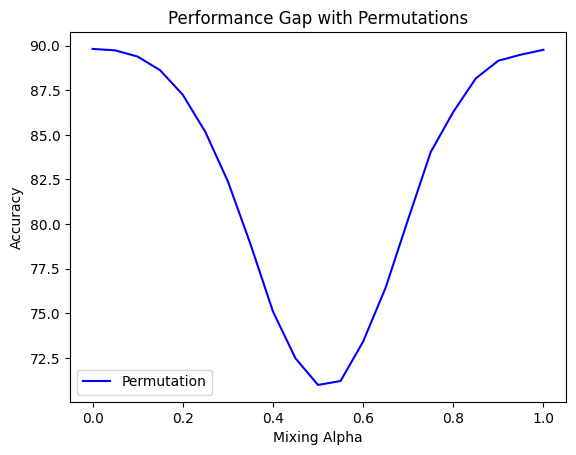

In [12]:
plt.plot(alphas, permuted_performances, 'blue', label='Permutation')
plt.title('Performance Gap with Permutations')
plt.xlabel('Mixing Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Merge Only Permuted First Layer

In [13]:
model1.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.11.weight', 'features.11.bias', 'features.13.weight', 'features.13.bias', 'features.16.weight', 'features.16.bias', 'features.18.weight', 'features.18.bias', 'classifier.weight', 'classifier.bias'])

In [26]:
mixable_weights = ['features.0.weight', 'features.0.bias']
alphas = np.arange(0, 1.05, .05)
model_a = vgg11()
permuted_performances = [
    get_post_alignment_performance(
        model_a, alpha, k0, k1, mixable_weights=mixable_weights
    ) for alpha in tqdm(alphas, position=0, leave=True)
]

100%|███████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:35<00:00,  1.68s/it]


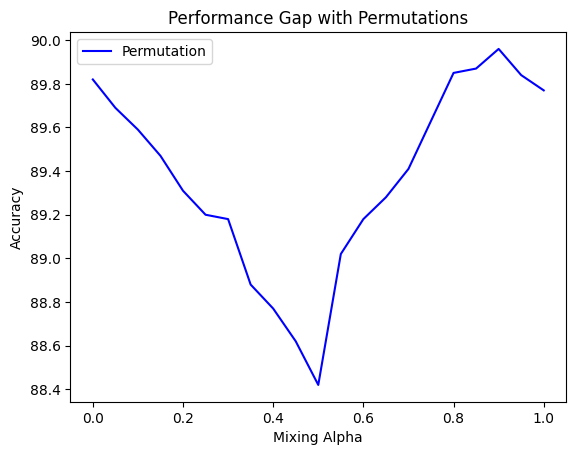

In [27]:
plt.plot(alphas, permuted_performances, 'blue', label='Permutation')
plt.title('Performance Gap with Permutations')
plt.xlabel('Mixing Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compare Permutation vs Greedy Matching at First Layer

In [42]:
model0.state_dict()['features.0.weight'].shape, model1.state_dict()['features.0.bias'].shape

(torch.Size([64, 3, 3, 3]), torch.Size([64]))

In [44]:
model0_w = model0.state_dict()['features.0.weight'].flatten(1)
model1_w = model1.state_dict()['features.0.weight'].flatten(1)

In [45]:
model0_w.shape, model1_w.shape

(torch.Size([64, 27]), torch.Size([64, 27]))

In [46]:
cos_sim = nn.CosineSimilarity(dim=1)

In [47]:
output_sims = cos_sim(model0_w, model1_w)

In [50]:
output_sims

tensor([0.3797, 0.9824, 0.9112, 0.7996, 0.7272, 0.7559, 0.2709, 0.7370, 0.4638,
        0.7310, 0.8742, 0.5318, 0.7405, 0.9377, 0.7206, 0.8569, 0.8852, 0.4220,
        0.1143, 0.8138, 0.4964, 0.8304, 0.6729, 0.4187, 0.2508, 0.9687, 0.0714,
        0.2768, 0.7209, 0.8796, 0.8963, 0.2734, 0.3103, 0.7109, 0.8969, 0.9689,
        0.8383, 0.9107, 0.6592, 0.7328, 0.3225, 0.4053, 0.6353, 0.5580, 0.2808,
        0.9176, 0.6147, 0.7362, 0.8106, 0.8038, 0.8971, 0.3708, 0.9884, 0.7706,
        0.8846, 0.6533, 0.3832, 0.8441, 0.4787, 0.9465, 0.8339, 0.3590, 0.4881,
        0.2462], device='cuda:0')

In [70]:
def mix_weights(net, alpha, sd0, sd1, conditional_fn=None, mixable_weights=None, ignore_features=None):
    sd_alpha = {}
    for k in sd0.keys():
        if (mixable_weights is not None and k in mixable_weights) or mixable_weights is None:
            sd_alpha[k] = (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
            if ignore_features is not None:
                sd_alpha[k][ignore_features] = sd0[k].cuda()[ignore_features]
        elif alpha <= .5:
            sd_alpha[k] = sd0[k].cuda()
        elif alpha > .5:
            sd_alpha[k] = sd1[k].cuda()
        else:
            raise ValueError('Weight Mixer Failed')
    net.load_state_dict(sd_alpha)

def get_post_alignment_performance(
    model_a, alpha, k0, k1, 
    mixer=mix_weights, 
    conditional_fn=lambda x: x<.0,
    mixable_weights=None
):
    mixer(model_a, alpha, k0, k1, conditional_fn=conditional_fn, mixable_weights=mixable_weights)
    return 100*evaluate(model_a)

In [72]:
k0 = 'vgg11_v1'
k1 = 'vgg11_v7'
model0 = vgg11()
model1 = vgg11()
model_permute = vgg11()
model1_base = vgg11()
model_bipartite = vgg11()
mix_weights(model0, 0.0, model0.state_dict(), model1.state_dict())
mix_weights(model1, 1.0, model0.state_dict(), model1.state_dict())
mix_weights(model1_base, 1.0, model0.state_dict(), model1.state_dict())
mix_weights(model_permute, 1.0, model0.state_dict(), model1.state_dict())
mix_weights(model_bipartite, 1.0, model0.state_dict(), model1.state_dict())

In [ ]:
# Greedy Bipartite matching
def bipartite_matching(corr):
    idx = corr.argmax(0)
    mapping = torch.eye(corr.shape[0], device=corr.device)[idx]
    total_collapsed = mapping.sum(0, keepdim=True) + 1.
    mapping = mapping / total_collapsed
    return mapping, total_collapsed

def get_layer_bipartite(net0, net1):
    corr_mtx = run_corr_matrix(net0, net1)
    bipartite_match, collapsed =  bipartite_matching(corr_mtx)
    return bipartite_match, collapsed

def bipartite_output(mapping, layer):
    pre_weights = [layer.weight, layer.bias]
    for w in pre_weights:
        if len(w.shape) == 4:
            w.data = torch.einsum('ab,bcde->abcd', mapping.t(), w)
        elif len(w.shape) == 2:
            w.data = mapping.t() @ w
        elif len(w.shape) == 1:
            w.data = w @ mapping

def bipartite_input(mapping, layer):
    pre_weights = [layer.weight, layer.bias]
    for w in pre_weights:
        if len(w.shape) == 4:
            w.data = torch.einsum('abcd,be->aecd', w, mapping)
        elif len(w.shape) == 2:
            w.data = w @ mapping
        elif len(w.shape) == 1:
            w.data = w @ mapping
    

In [104]:
from collections import defaultdict

In [106]:
def subnet(model, n_layers):
    return model.features[:n_layers]

def reweight_source_features(source, weights):
    for param in [source.weight, source.bias]:
        if len(param.shape) == 4:
            weights = weights.view(-1, 1, 1, 1)
        elif len(param.shape) == 2:
            weights = weights.view(-1, 1)
        else:
            weights = weights
        param.data = param / weights

def align_target_to_source(source, target, variant='permute'):
    source_feats = source.features
    target_feats = target.features
    layer2ignored_feats = defaultdict(lambda: dict())
    
    n = len(source_feats)
    for i in range(n):
        if not isinstance(source_feats[i], nn.Conv2d):
            continue
        assert isinstance(source_feats[i+1], nn.ReLU)
        source_layer = subnet(source, i+2)
        target_layer = subnet(target, i+2)
        layer2ignored_feats[source_layer]['output_ignore'] = torch.zeros(
            source_layer.shape[0], device=source_layer.device
        )
        if variant == 'permute':
            mapping = get_layer_perm(source_layer, target_layer)
            permute_output(mapping, target_feats[i])
            layer2ignored_feats[source_layer]['output_ignore'] = torch.zeros(
                source_layer.shape[0], device=source_layer.device
            )
        elif variant == 'bipartite':
            mapping, total_matched = get_layer_bipartite(source_layer, target_layer)
            bipartite_output(mapping, target_feats[i])
            layer2ignored_feats[source_layer]['output_ignore'] = total_matched.reshape(-1)
            
        next_layer = None
        for j in range(i+1, n):
            if isinstance(source_feats[j], nn.Conv2d):
                next_layer = target_feats[j]
                break
            if next_layer is None:
                next_layer = target_feats[j]
            
            if variant == 'permute':
                permute_input(mapping, next_layer)
                layer2ignored_feats[next_layer]['input_ignore'] = torch.zeros(
                next_layer.shape[1], device=next_layer.device
            )
            elif variant == 'bipartite':
                bipartite_input(mapping, next_layer)
                layer2ignored_feats[next_layer]['input_ignore'] = total_matched.reshape(-1)
    return layer2ignored_feats
        

In [103]:
[i for i in feats1.children() if hasattr(i, 'weight')][0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
permuted_layer2ignored_feats = align_target_to_source(
    
)

In [63]:
feats1 = model1.features
feats_permute = model_permute.features
feats_bipartite = model_bipartite.features

n = len(feats1)
for i in range(n):
    if not isinstance(feats1[i], nn.Conv2d):
        continue
    
    # permute the outputs of the current conv layer
    assert isinstance(feats1[i+1], nn.ReLU)
    first_conv_perm_map = get_layer_perm(subnet(model0, i+2), subnet(model_permute, i+2))
    first_conv_bipartite_map, bipartite_collapsed = get_layer_bipartite(
        subnet(model0, i+2), subnet(model_bipartite, i+2)
    )
    permute_output(first_conv_perm_map, feats_permute[i])
    bipartite_output(first_conv_bipartite_map, feats_bipartite[i])
    break


  0%|                                                                                                | 0/11 [10:54<?, ?it/s]

  0%|                                                                                                | 0/11 [10:54<?, ?it/s]

  0%|                                                                                                | 0/11 [04:13<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.09it/s]

  0%|                                                                                                | 0/11 [09:40<?, ?it/s]


  0%|                                                                                                | 0/11 [04:18<?, ?it/s]

  0%|                                                                                                | 0/11 [04:18<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.78it/s]


In [55]:
save_model(model_permute, 'vgg11_v2_perm1_FirstLayer')
save_model(model_bipartite, 'vgg11_v2_bipartite_FirstLayer')

In [56]:
first_conv_perm_map

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [57]:
first_conv_bipartite_map.cpu().numpy()[:, 1]

array([0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
      dtype=float32)

In [58]:
torch.eye(64)[:, first_conv_perm_map].numpy()[:, 1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [59]:
def find_bipartite_selections(mapping):
    position2selections = {}
    for i in range(mapping.shape[1]):
        elements = mapping[:, i].cpu().nonzero().flatten().numpy().tolist()
        position2selections[i] = elements
    return position2selections

In [60]:
print(find_bipartite_selections(first_conv_bipartite_map))

{0: [0, 7, 8, 11, 17, 20, 22, 23, 24, 26, 31, 32, 38, 41, 43, 44, 46, 58, 61, 62, 63], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [], 8: [], 9: [9], 10: [10], 11: [], 12: [12], 13: [13], 14: [14], 15: [15], 16: [16], 17: [], 18: [18], 19: [19], 20: [], 21: [21], 22: [], 23: [], 24: [], 25: [25], 26: [], 27: [27], 28: [28], 29: [29], 30: [30], 31: [], 32: [], 33: [33], 34: [34], 35: [35], 36: [36], 37: [37], 38: [], 39: [39], 40: [40], 41: [], 42: [42], 43: [], 44: [], 45: [45], 46: [], 47: [47], 48: [48], 49: [49], 50: [50], 51: [51], 52: [52], 53: [53], 54: [54], 55: [55], 56: [56], 57: [57], 58: [], 59: [59], 60: [60], 61: [], 62: [], 63: []}


In [61]:
print({i:j.numpy().tolist() for i, j in enumerate(first_conv_perm_map)})

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63}


In [49]:
mixable_weights = ['features.0.weight', 'features.0.bias']
alphas = np.arange(0, .505, .05)
model_a = vgg11()
bipartite_performances = [
    get_post_alignment_performance(
        model_a, 
        alpha, 
        k0='vgg11_v1', 
        k1='vgg11_v2_bipartite_FirstLayer', 
        mixable_weights=mixable_weights
    ) for alpha in tqdm(alphas, position=0, leave=True)
]

# permuted_performances = [
#     get_post_alignment_performance(
#         model_a, 
#         alpha, 
#         k0='vgg11_v1', 
#         k1='vgg11_v2_perm1_FirstLayer', 
#         mixable_weights=mixable_weights
#     ) for alpha in tqdm(alphas, position=0, leave=True)
# ]

plt.plot(alphas, bipartite_performances, 'blue', label='BiPartite')
plt.plot(alphas, copy_permuted_performances, 'red', label='Permutation')
plt.title('Performance Gap with Permutations')
plt.xlabel('Mixing Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

  0%|                                                                                                | 0/11 [00:00<?, ?it/s]

> /tmp/ipykernel_84134/2213140043.py(15)mix_weights()
     13             param0 = sd0[k].cuda()
     14             pdb.set_trace()
---> 15             param0 = param0 / (bipartite_collapsed.view(-1,1,1,1) if len(param0.shape) == 4 else bipartite_collapsed)
     16             sd_alpha[k] = (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
     17             sd_alpha[k][bipartite_collapsed == 1.] = sd0[k].cuda()

ipdb> bipartite_collapsed
tensor([[1., 2., 1., 2., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         2., 1., 1., 1., 1., 1., 1., 1., 1., 4., 1., 2., 1., 1., 1., 3., 1., 1.,
         1., 1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
         1., 1., 2., 5., 1., 1., 2., 1., 1., 1.]], device='cuda:0')
ipdb> n
> /tmp/ipykernel_84134/2213140043.py(16)mix_weights()
     14             pdb.set_trace()
     15             param0 = param0 / (bipartite_collapsed.view(-1,1,1,1) if len(param0.shape) == 4 else bipartite_collapsed)
---> 16           